In [2]:
import numpy as np
from scipy import signal, interpolate
import quaternion

import matplotlib.pyplot as plt

from copy import copy

import seaborn as sns
sns.set_context('notebook', font_scale=1.5)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6  # that's default image size for this interactive session

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from test_imu_algorithms import IMU_test_data

Set up test data from 0 to 50 seconds at 200Hz

In [5]:
imu = IMU_test_data((0, 50, 1.0/200))

Initial chip orientation

In [6]:
roll0 = np.deg2rad(85) # (-85)
pitch0 = np.deg2rad(87) # (-93)
yaw0 = np.deg2rad(5)

In [7]:
Rx = np.array([[1, 0, 0],
               [0, np.cos(roll0), np.sin(roll0)],
               [0, -np.sin(roll0), np.cos(roll0)]])
Ry = np.array([[np.cos(pitch0), 0, np.sin(pitch0)],
               [0, 1, 0],
               [-np.sin(pitch0), 0, np.cos(pitch0)]])
Rz = np.array([[np.cos(yaw0), np.sin(yaw0), 0],
               [-np.sin(yaw0), np.cos(yaw0), 0],
               [0, 0, 1]])

R0 = Rx.dot(Ry.dot(Rz))
imu.set_initial_orientation(R0)

In [8]:
np.round(R0, decimals=3)

array([[ 0.052,  0.005,  0.999],
       [-0.999,  0.   ,  0.052],
       [ 0.   , -1.   ,  0.005]])

In [9]:
r, p, y = imu._rotm2eul(R0)
print np.rad2deg([r, p, y])

[ 85.  87.   5.]


Set up noise parameters

In [10]:
imu.set_noise_params(gyrorms=5.0,          # deg/sec
                     gyrofreq=20.0,        # Hz
                     gyrodriftrms=0.0,     # deg/sec
                     gyrodriftfreq=0.1,    # Hz
                     accrms=0.03,          # g
                     accfreq=33)           # Hz

Generate the arm data

In [11]:
imu.generate_arm_data(alpham=np.deg2rad(15), # 15deg
                      Am=0.15, # 0.15m back and forth
                      f=0.7, # 0.7Hz oscillation
                      l=0.4,
                      delta=0.2) # 20% phase lag between angle and forward back motion

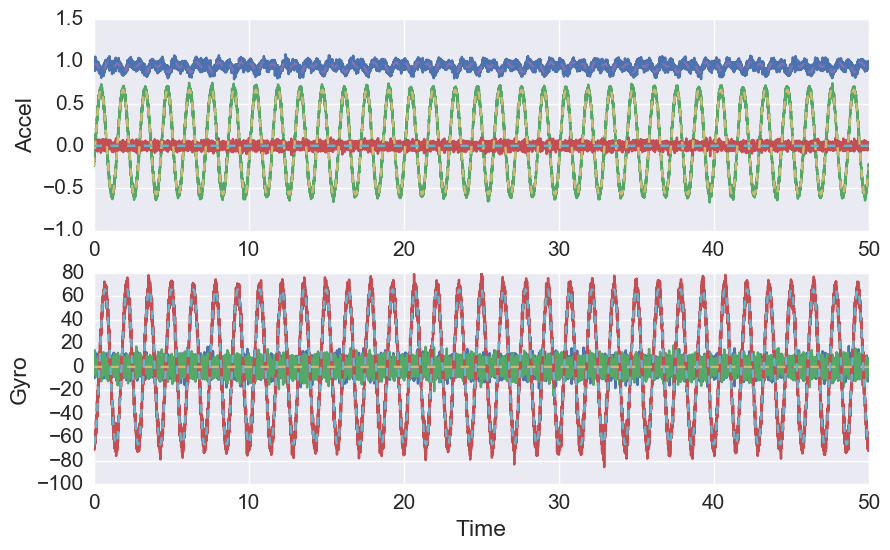

In [12]:
fig, ax = plt.subplots(2,1)
ax[0].plot(imu.t, imu.acc0)
ax[0].plot(imu.t, imu.acc_nonoise, '--')
ax[0].set_ylabel('Accel')

ax[1].plot(imu.t, imu.gyro0)
ax[1].plot(imu.t, imu.gyro_nonoise, '--')
ax[1].set_ylabel('Gyro')
ax[1].set_xlabel('Time')
plt.show()

Set up initial orientation for EKF algorithm

In [41]:
imu.filter(nsamp=10, method='running')

imu.calibrate(duration=30.0)
imu.get_inertial_coords(duration=30.0)
imu.get_world_coordinates(duration=30.0)

Check how close the estimated chip orientation is to the real chip orientation

In [63]:
print "Estimated orientation:\n{}".format(np.round(imu.chip2world_rot, decimals=3))
print "\nTrue orientation:\n{}".format(np.round(imu.R0, decimals=3))

print "\nDifference:\n{}".format(np.round(imu.chip2world_rot - imu.R0, decimals=5))
print "\nNorm of difference: {}".format(np.linalg.norm(imu.chip2world_rot - imu.R0))

Estimated orientation:
[[ 0.055  0.005  0.998]
 [-0.998 -0.     0.055]
 [ 0.001 -1.     0.005]]

True orientation:
[[ 0.052  0.005  0.999]
 [-0.999  0.     0.052]
 [ 0.    -1.     0.005]]

Difference:
[[ 0.00265  0.00069 -0.00015]
 [ 0.00014 -0.00049  0.00265]
 [ 0.00054  0.       0.00066]]

Norm of difference: 0.00394095565463


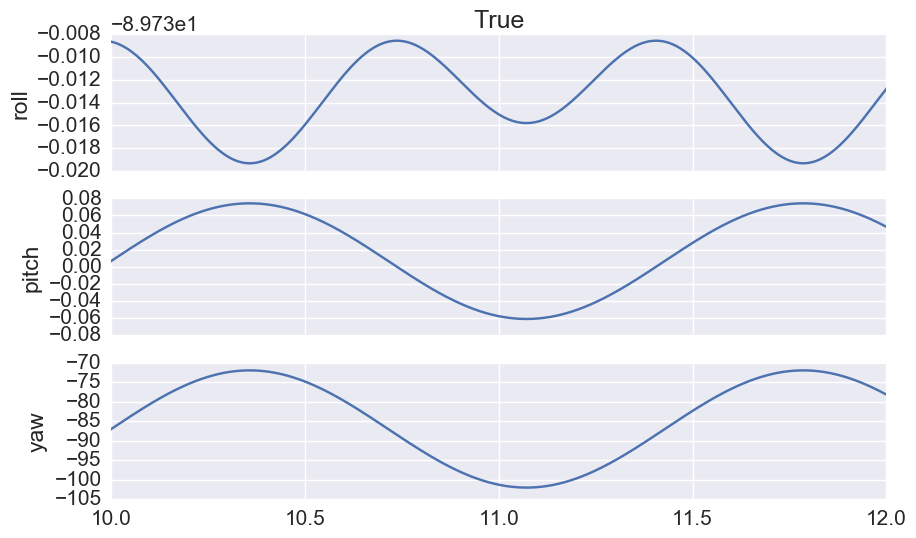

In [43]:
fig, ax = plt.subplots(3,1, sharex=True)
for o1, ax1, lab in zip(np.rollaxis(imu.orient_imu_true, 1), ax, ['roll', 'pitch', 'yaw']):
    ax1.plot(imu.t, o1, label='true')
    ax1.set_ylabel(lab)
ax[0].set_title('True')
ax[0].set_xlim([10, 12])
plt.show()

In [44]:
imu.get_orientation(method='ekf', lCa=(0.0, -0.3, -0.7))
orient_ekf_chip = copy(imu.orient_sensor)
orient_ekf_world = copy(imu.orient_world)
accdyn_chip1 = copy(imu.accdyn_sensor)
accdyn_chip2 = copy(imu.accdyn_sensor2)
accdyn_world = copy(imu.accdyn_world)

(10, 12)

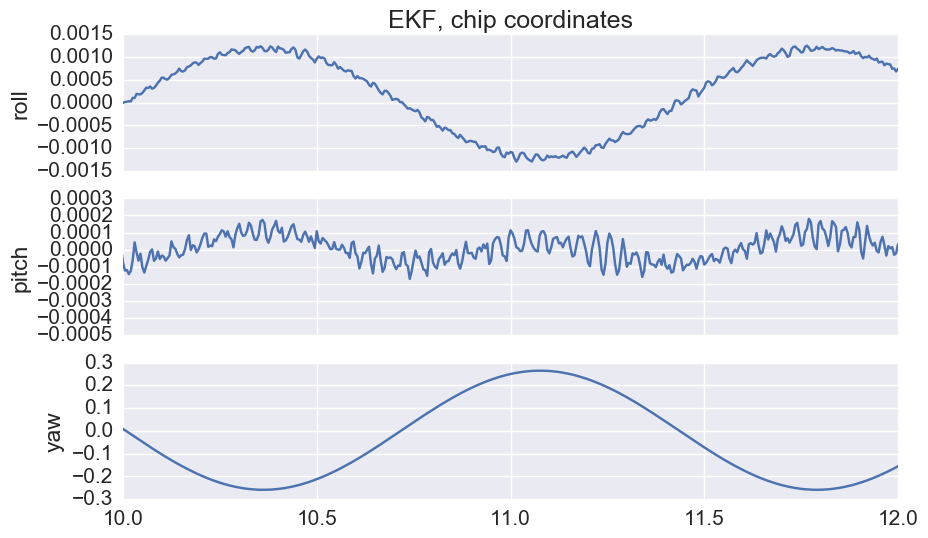

In [45]:
fig, ax = plt.subplots(3,1, sharex=True)
for o1, ax1, lab in zip(np.rollaxis(orient_ekf_chip, 1), ax, ['roll', 'pitch', 'yaw']):
    ax1.plot(imu.t, o1, label='ekf')
    ax1.set_ylabel(lab)
ax[0].set_title('EKF, chip coordinates')
ax[0].set_xlim([10, 12])

(10, 12)

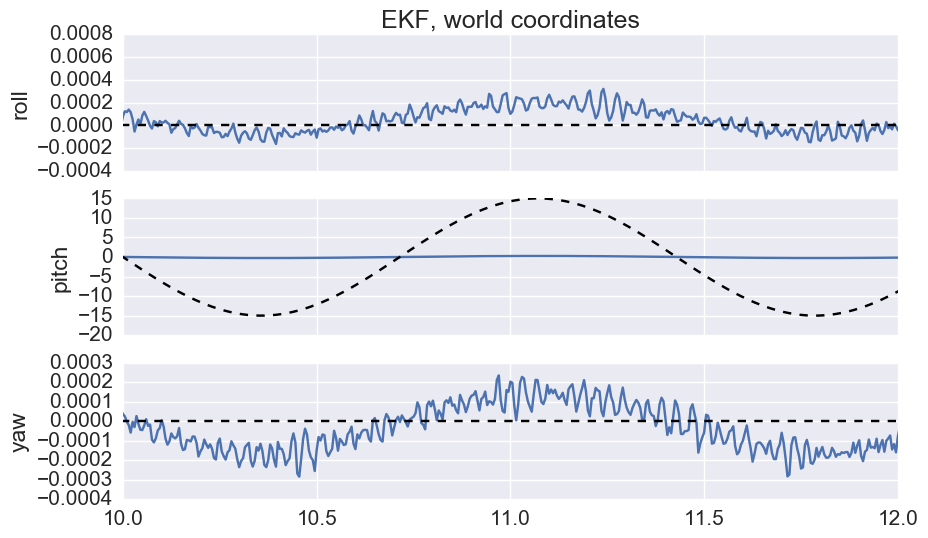

In [49]:
fig, ax = plt.subplots(3,1, sharex=True)
for o1, o2, ax1, lab in zip(np.rollaxis(orient_ekf_world, 1), np.rollaxis(imu.orient_world_true, 1), ax, ['roll', 'pitch', 'yaw']):
    ax1.plot(imu.t, o1, label='ekf')
    ax1.plot(imu.t, o2, 'k--', label='true')
    ax1.set_ylabel(lab)
ax[0].set_title('EKF, world coordinates')
ax[0].set_xlim([10, 12])

(10, 12)

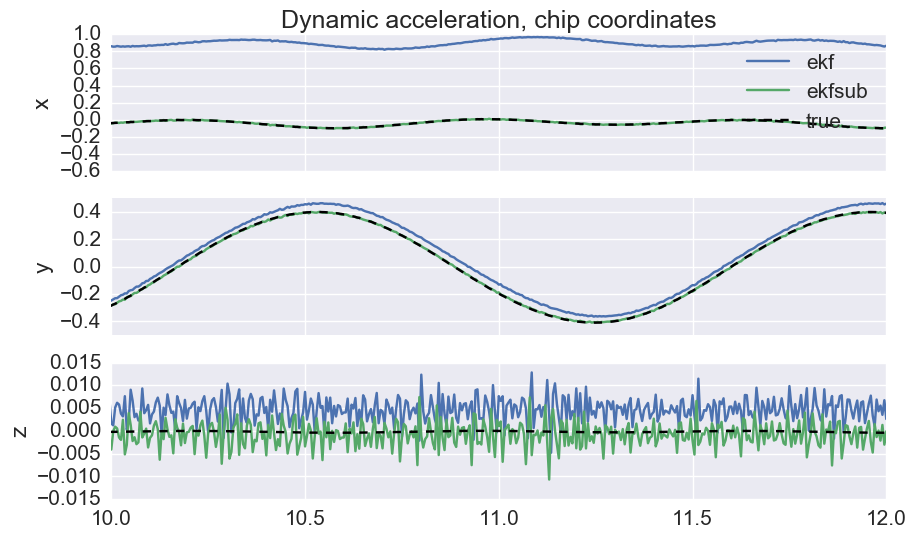

In [58]:
fig, ax = plt.subplots(3,1, sharex=True)
for a0, a1, a2, ax1, lab in zip(np.rollaxis(imu.accdyn_imu_true, 1), 
                                    np.rollaxis(imu.accdyn_sensor, 1),
                                    np.rollaxis(imu.accdyn_sensor2, 1), ax, ['x', 'y', 'z']):
    ax1.plot(imu.t, a1/9.81, label='ekf')
    ax1.plot(imu.t, a2, label='ekfsub')
    ax1.plot(imu.t, a0, 'k--', label='true')
    ax1.set_ylabel(lab)
ax[0].set_title('Dynamic acceleration, chip coordinates')
ax[0].legend()
ax[0].set_xlim([10, 12])

(10, 12)

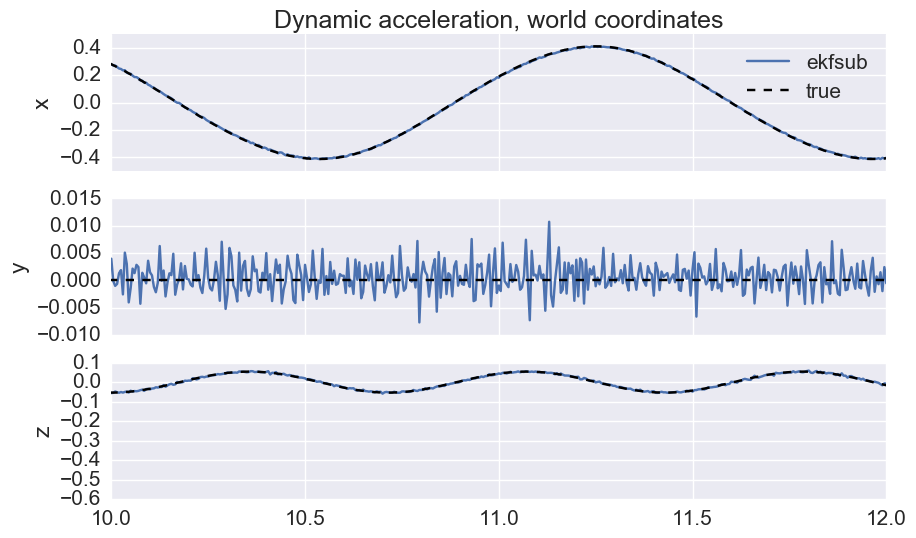

In [59]:
fig, ax = plt.subplots(3,1, sharex=True)
for a0, a1, ax1, lab in zip(np.rollaxis(imu.accdyn_world_true, 1), 
                                    np.rollaxis(imu.accdyn_world, 1),
                                    ax, ['x', 'y', 'z']):
    ax1.plot(imu.t, a1, label='ekfsub')
    ax1.plot(imu.t, a0, 'k--', label='true')
    ax1.set_ylabel(lab)
ax[0].set_title('Dynamic acceleration, world coordinates')
ax[0].legend()
ax[0].set_xlim([10, 12])

In [46]:
orient2 = []
for rpy in orient_ekf_chip:
    Rchip = imu._eul2rotm(rpy)
    R0 = imu.R0 # imu.chip2world_rot
    R2 = R0.T.dot(Rchip.dot(R0))
    orient2.append(imu._rotm2eul(R2))
orient2 = np.array(orient2)

In [47]:
orient3 = []
R0 = imu.chip2world_rot
for chiprpy in orient_ekf_chip:
    Rchip = imu._eul2rotm(chiprpy)
    R = Rchip.dot(R0)

    worldrotm = R0.T.dot(R)
    orient3.append(imu._rotm2eul(worldrotm))
orient3 = np.array(orient3)

(10, 12)

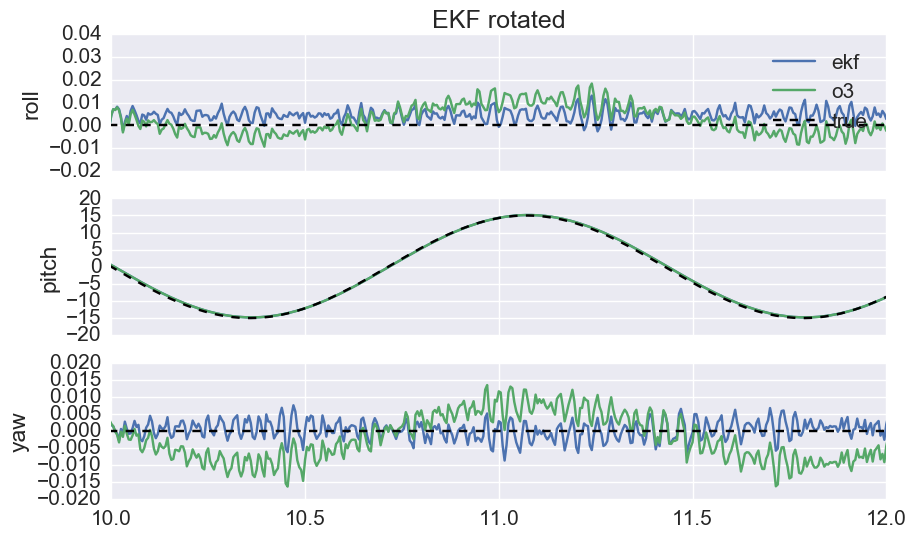

In [48]:
fig, ax = plt.subplots(3,1, sharex=True)
for o1, o2, o3, ax1, lab in zip(np.rollaxis(imu.orient_world_true, 1), np.rollaxis(orient2, 1),
                                np.rollaxis(orient3, 1), ax, ['roll', 'pitch', 'yaw']):
    ax1.plot(imu.t, np.rad2deg(o2), label='ekf')
    ax1.plot(imu.t, np.rad2deg(o3), label='o3')
    ax1.plot(imu.t, o1, 'k--', label='true')
    ax1.set_ylabel(lab)
ax[0].set_title('EKF rotated')
ax[0].legend()
ax[0].set_xlim([10, 12])

In [86]:
print np.round(imu.chip2world_rot, decimals=3)
print np.round(imu.R0, decimals=3)

[[ 0.052 -0.     0.999]
 [-0.995  0.087  0.052]
 [-0.087 -0.996  0.005]]
[[ 0.052  0.005  0.999]
 [-0.999  0.     0.052]
 [ 0.    -1.     0.005]]


In [80]:
g_chip = []
acc_chip = []
acc_world = []
g0 = np.array([0, 0, 1.0])
for rpy, acc1 in zip(orient_ekf1, imu.acc):
    Rchip = imu._eul2rotm(rpy)
    R = Rchip.dot(imu.chip2world_rot)
    
    g1 = Rchip.dot(imu.chip2world_rot).dot(g0)
    ad = acc1 - g1
    aw = R.T.dot(ad)
    
    g_chip.append(g1)
    acc_chip.append(ad)
    acc_world.append(aw)
    
g_chip = np.array(g_chip)
acc_chip = np.array(acc_chip)
acc_world = np.array(acc_world)

(10, 12)

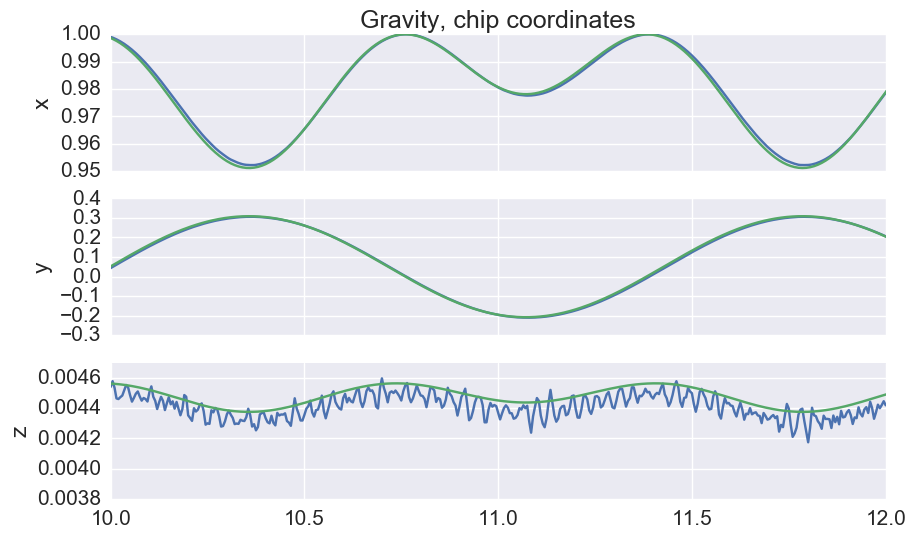

In [81]:
fig, ax = plt.subplots(3,1, sharex=True)
for g0, g1, ax1, lab in zip(np.rollaxis(g_chip, 1), np.rollaxis(imu.g_imu, 1), ax, ['x', 'y', 'z']):
    ax1.plot(imu.t, g0, label='ekf')
    ax1.plot(imu.t, g1, label='true')
    # ax1.plot(imu.t, g1, label='g')
    ax1.set_ylabel(lab)
ax[0].set_title('Gravity, chip coordinates')
ax[0].set_xlim([10, 12])

(10, 12)

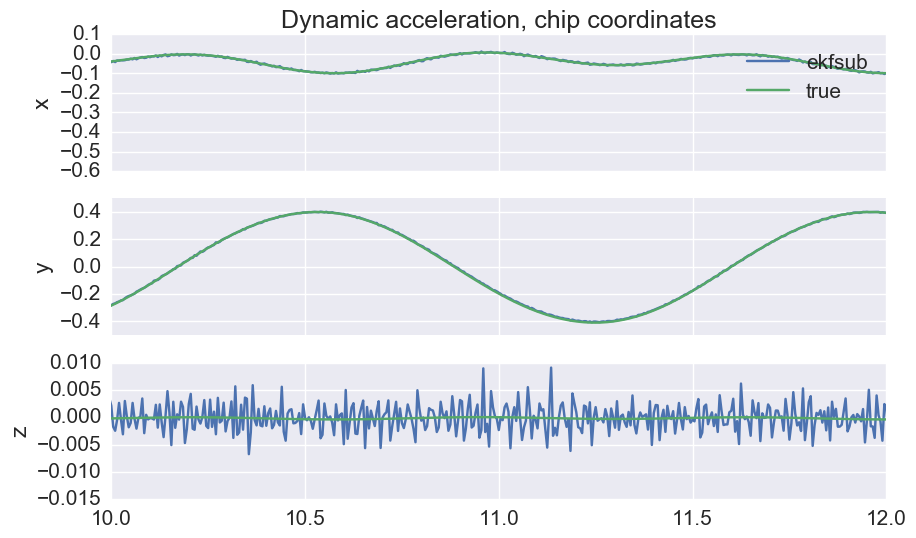

In [82]:
fig, ax = plt.subplots(3,1, sharex=True)
for a1, a2, a0, g1, ax1, lab in zip(np.rollaxis(accd1, 1), np.rollaxis(acc_chip, 1), np.rollaxis(imu.accdyn_imu_true, 1), 
                            np.rollaxis(imu.g_imu, 1), ax, ['x', 'y', 'z']):
    # ax1.plot(imu.t, a1/9.81, label='ekf')
    ax1.plot(imu.t, a2, label='ekfsub')
    ax1.plot(imu.t, a0, label='true')
    # ax1.plot(imu.t, g1, label='g')
    ax1.set_ylabel(lab)
ax[0].set_title('Dynamic acceleration, chip coordinates')
ax[0].legend()
ax[0].set_xlim([10, 12])

(10, 12)

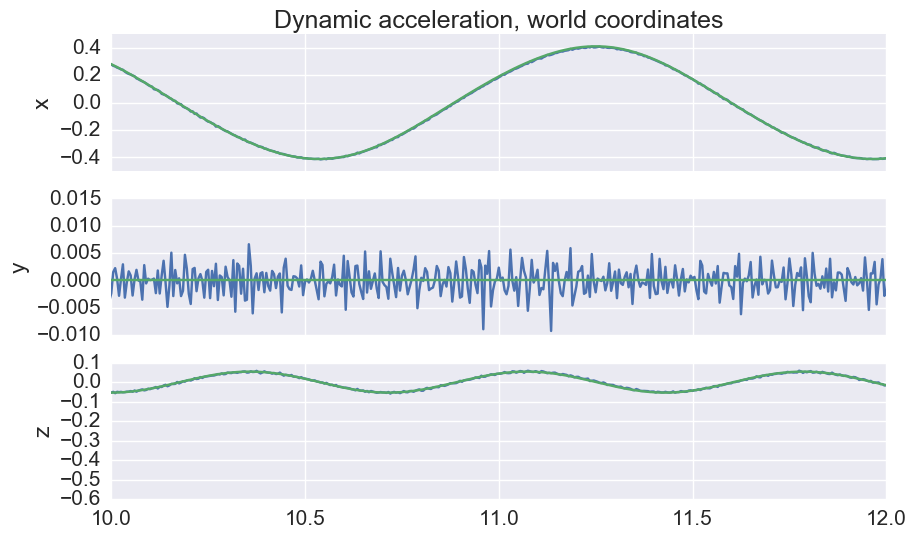

In [83]:
fig, ax = plt.subplots(3,1, sharex=True)
for a1, a2, g1, ax1, lab in zip(np.rollaxis(acc_world, 1), np.rollaxis(imu.accdyn_world_true, 1), 
                            np.rollaxis(imu.g_imu, 1), ax, ['x', 'y', 'z']):
    ax1.plot(imu.t, a1, label='ekf')
    ax1.plot(imu.t, a2, label='true')
    # ax1.plot(imu.t, g1, label='g')
    ax1.set_ylabel(lab)
ax[0].set_title('Dynamic acceleration, world coordinates')
ax[0].set_xlim([10, 12])

In [92]:
q = []
for o1 in orient_ekf1:
    q1 = quaternion.from_euler_angles(*o1)
    q.append(q1/abs(q1))
q = np.array(q)

In [93]:
qorient_world = []
for q1 in q:
    q2 = q1 * q0
    qorient_world.append(q2/abs(q2))
qorient_world = np.array(qorient_world)

In [94]:
abs(q0)

1.0

In [95]:
orient_world2 = []
for q1 in qorient_world:
    orient_world2.append(quaternion.as_euler_angles(q1))
orient_world2 = np.array(orient_world2)

In [96]:
orient_world = []
for rpy in orient_ekf1:
    R1 = imu._eul2rotm(np.deg2rad(rpy))
    Rworld = R1.dot(imu.R0)
    orient_world.append(imu._rotm2eul(Rworld))
orient_world = np.array(orient_world)

(10, 12)

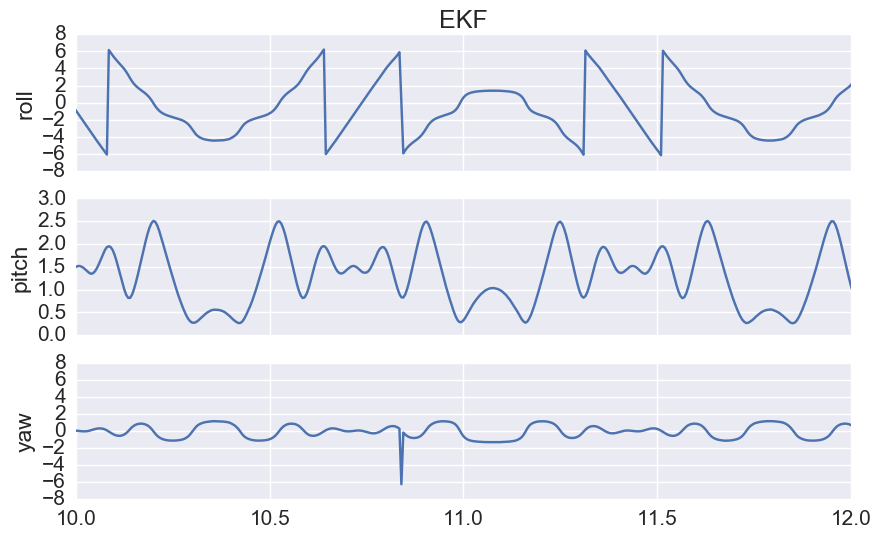

In [97]:
fig, ax = plt.subplots(3,1, sharex=True)
for o1, ax1, lab in zip(np.rollaxis(orient_world2, 1), ax, ['roll', 'pitch', 'yaw']):
    ax1.plot(imu.t, o1, label='ekf')
    ax1.set_ylabel(lab)
ax[0].set_title('EKF')
ax[0].set_xlim([10, 12])

NameError: name 'orient_world' is not defined

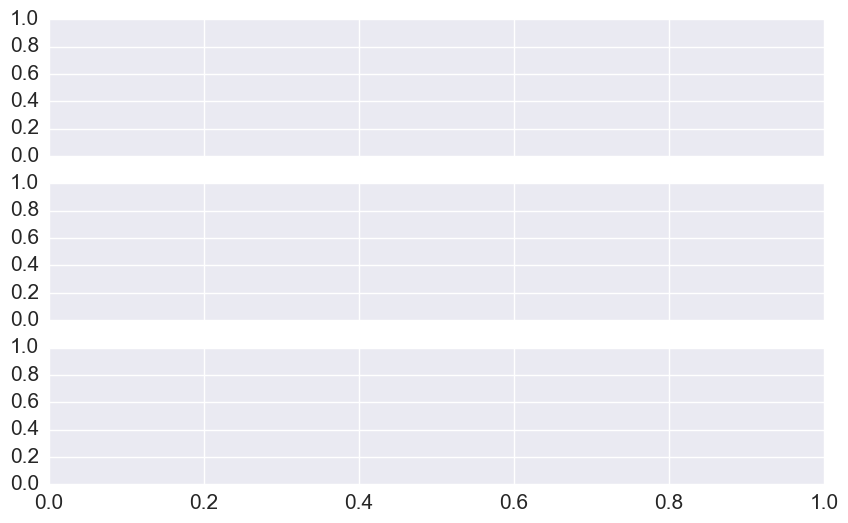

In [90]:
fig, ax = plt.subplots(3,1, sharex=True)
ax[0].plot(imu.t, orient_world[:,0], label='EKF')
ax[0].plot(imu.t, np.deg2rad(imu.orient_world_true[:, 0]), 'k--')

ax[1].plot(imu.t, orient_world[:,1], label='EKF')
ax[1].plot(imu.t, np.deg2rad(imu.orient_world_true[:, 1]), 'k--')

ax[2].plot(imu.t, orient_world[:,2], label='EKF')
ax[2].plot(imu.t, np.deg2rad(imu.orient_world_true[:, 2]), 'k--')

ax[0].set_title('World from EKF')
ax[0].set_xlim([10, 12])

(10, 12)

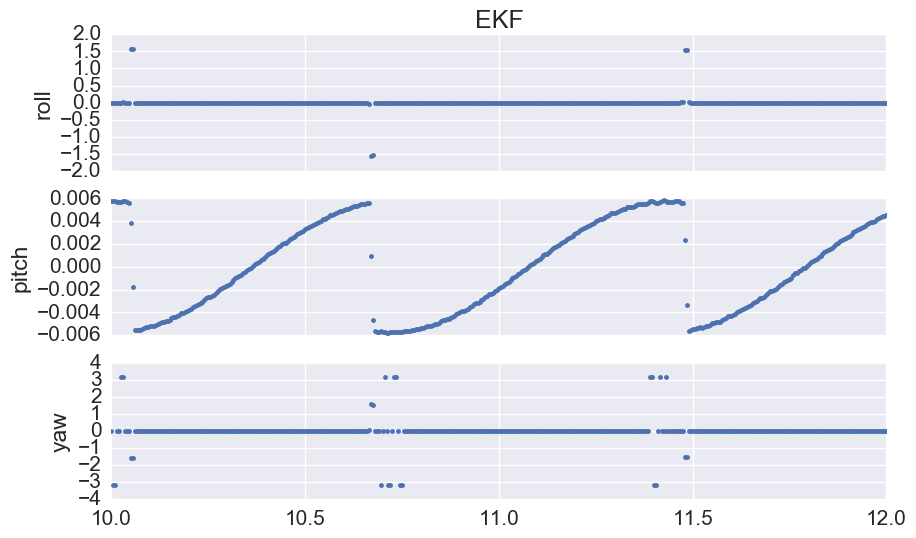

In [82]:
fig, ax = plt.subplots(3,1, sharex=True)
for o1, ax1, lab in zip(np.rollaxis(np.gradient(orient_world, axis=0), 1), ax, ['roll', 'pitch', 'yaw']):
    ax1.plot(imu.t, o1, '.', label='ekf')
    ax1.set_ylabel(lab)
ax[0].set_title('EKF')
ax[0].set_xlim([10, 12])

In [68]:
rpy = np.deg2rad(imu.orient_world_true)
rpyprev = rpy[0,:]

In [75]:
off = np.zeros((3,))
mul = np.ones((3,))

jump = np.pi - 0.01

rpynew = copy(rpy)

for i in range(1, rpy.shape[0]):
    rpynew[i, :] *= mul
    rpynew[i, :] += off

    if abs(rpynew[i, 0] - rpynew[i-1, 0]) >= jump:
        mul *= [-1, -1, -1]
        off += [0, np.pi/2, 0]

        off = np.mod(off, np.pi)
        rpynew[i, :] *= mul
        rpynew[i, :] += off

(10, 12)

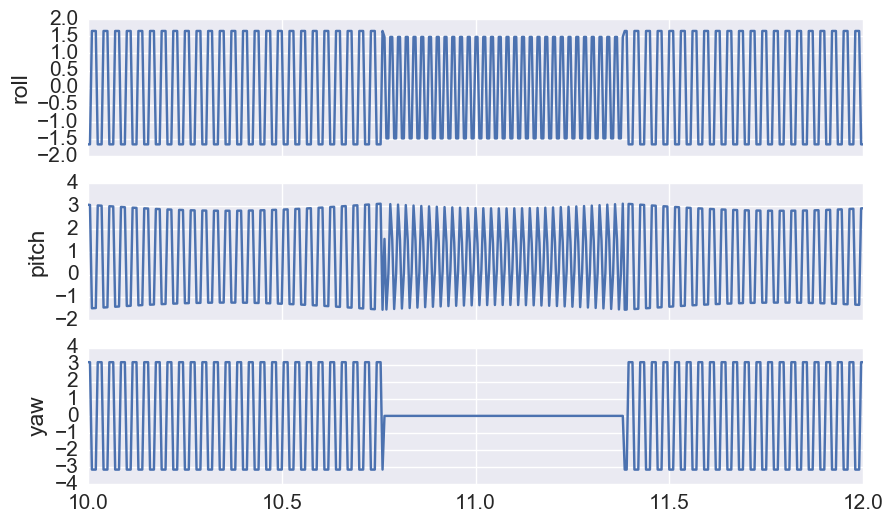

In [76]:
fig, ax = plt.subplots(3,1, sharex=True)

for o1, ax1, lab in zip(np.rollaxis(rpynew, 1), ax, ['roll', 'pitch', 'yaw']):
    ax1.plot(imu.t, o1, label='corr')
    ax1.set_ylabel(lab)

ax[0].set_xlim([10, 12])